In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import glob
import pybedtools as pbt
from ipyparallel import Client
from sklearn import metrics
from itertools import product

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

## The objective here is to demonstrate that Expectation scores predict the G4 structures better than Quadparser and G4Hunter algorithms. For this two approaches will be used.

### First using G4-Seq data, all the genomic regions that either have OQs or do not have OQs (i.e. regions sequenced but did not show only a marginal mismatch rate) were identified. Now using these regions TP, FN, FP, TN were identified using different Expectation value cutoffs. (Will run for approx 55 minutes)

In [2]:
def evaluate_positions_wrapper(chrom, strand):
    import numpy as np
      
    def evaluate_positions(bed_file, strand):
        h = open(bed_file)
        bed_data = h.readlines()
        h.close()
        cutoff_values = list(range(1, 200)) + list(range(200, 1010, 10))
        pos_vals = [0 for x in cutoff_values]
        neg_vals = [0 for x in cutoff_values]
        for l in bed_data:
            c = l.rstrip('\n').split('\t')
            if c[3] == strand:
                start = int(c[1])
                stop = int(c[2])
                positions_scores = scores[start:stop]
                positions_scores = positions_scores[positions_scores > 1]
                for n,cutoff in enumerate(cutoff_values):
                    a = len(np.where(positions_scores >= cutoff)[0])
                    pos_vals[n] += a
                    neg_vals[n] += len(positions_scores) - a
        return pos_vals, neg_vals

    if strand == "+":
        opp_strand = 'negative'
    elif strand == "-":
        opp_strand = 'positive'
    else:
        raise ValueError("Strand should be either '+' or '-'")

    base_dir = '/home/parashar/scratch/quadcomb/data'
    scores = np.load('%s/snipr/%s_%s_scores.npy' % 
                     (base_dir, chrom, opp_strand), mmap_mode='r')
    true_p, false_neg = evaluate_positions(
        "%s/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % (base_dir, chrom),
            strand)
    false_p, true_neg  =  evaluate_positions(
        "%s/ROC_data/regions/chrom_wise/Na_K_2_no_oq_regions_%s.bed" % (base_dir, chrom),
            strand)
    return true_p, false_neg, false_p, true_neg

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(evaluate_positions_wrapper, *[chroms*2, (np.repeat(['+', '-'], 24))])

tp, fn, fp, tn = np.array(res).sum(axis=0)
cutoff_values = list(range(1, 200)) + list(range(200, 1010, 10))
for i in zip(cutoff_values, tp, fn, fp, tn):
    print (i)

sniprq_tpr = tp / (tp + fn)
sniprq_fpr = fp / (fp + tn)
np.save('../data/ROC_data/K2_SNIPRQ_TPR', sniprq_tpr)
np.save('../data/ROC_data/K2_SNIPRQ_FPR', sniprq_fpr)

(1, 15273071, 0, 352121591, 0)
(2, 15273071, 0, 352121591, 0)
(3, 15203031, 70040, 348631096, 3490495)
(4, 15127546, 145525, 344721864, 7399727)
(5, 14996894, 276177, 338093523, 14028068)
(6, 14720719, 552352, 324809832, 27311759)
(7, 14587553, 685518, 318201101, 33920490)
(8, 14415095, 857976, 309766798, 42354793)
(9, 14132001, 1141070, 297270398, 54851193)
(10, 13994815, 1278256, 290750789, 61370802)
(11, 13827116, 1445955, 282745583, 69376008)
(12, 13524219, 1748852, 269910188, 82211403)
(13, 13405463, 1867608, 264311085, 87810506)
(14, 13232544, 2040527, 256295294, 95826297)
(15, 12977745, 2295326, 246279922, 105841669)
(16, 12877168, 2395903, 241691674, 110429917)
(17, 12718698, 2554373, 234658934, 117462657)
(18, 12443424, 2829647, 223986416, 128135175)
(19, 12347011, 2926060, 219668643, 132452948)
(20, 12213495, 3059576, 214103239, 138018352)
(21, 12080548, 3192523, 209443873, 142677718)
(22, 11989795, 3283276, 205437009, 146684582)
(23, 11852456, 3420615, 199571754, 152549837)


### Similarly TP, FN, FP and TN were identified for the Quadparser. Will take around 2.30 min with 30 cores.

In [37]:
def evaluate_motif_positions_wrapper(chrom):
    import pybedtools as pbt

    def evaluate_motif_positions(region_bed_file):
        g4_bed_file = "/home/parashar/scratch/quadruplexes/hg19/g3_%d_%d_%s_nov.bed" % (
            int(loop), int(bulge), chrom)
        fixed_g4_bed = []
        with open(g4_bed_file) as h:
            for l in h:
                c = l.split('\t')
                strand = "+" if c[4][0] == "G" else "C"
                fixed_g4_bed.append("\t".join([
                    c[0], c[1], c[2], '.', '0', strand
                ]))
        g4_bed = pbt.BedTool("\n".join(fixed_g4_bed), from_string=True)

        fixed_region_bed = []
        with open(region_bed_file) as h:
            for l in h:
                c = l.split('\t')
                fixed_region_bed.append("\t".join([
                    c[0], c[1], c[2], '.', '0', c[3]
                ]))
        region_bed = pbt.BedTool("\n".join(fixed_region_bed), from_string=True)
        overlap = region_bed.intersect(g4_bed, S=True, u=True).count()
        return overlap, len(fixed_region_bed) - overlap
    
    res = []
    regions_dir = '/home/parashar/scratch/quadcomb/data/ROC_data/regions/chrom_wise'
    for bulge in [0, 5]:
        for loop in [3, 5, 7, 10, 15, 20, 25]:
            g4_base_dir = '/home/parashar/scratch/quadruplexes/hg19'
            g4_bed_file = "%s/g3_%d_%d_%s_nov.bed" % (g4_base_dir, loop, bulge, chrom)
            base_dir = '/home/parashar/scratch/quadcomb/data'
            true_p, false_neg = evaluate_motif_positions(
                "%s/Na_K_2_oq_regions_%s.bed" % (regions_dir, chrom))
            false_p, true_neg = evaluate_motif_positions(
                "%s/Na_K_2_no_oq_regions_%s.bed" % (regions_dir, chrom))
            res.append([true_p, false_neg, false_p, true_neg])
    return res

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(evaluate_motif_positions_wrapper, chroms)

tp, fn, fp, tn = np.array(res).sum(axis=0).T
for i in zip(list(product([0,5], [3, 5, 7, 10, 15, 20, 25])),
             tp, fn, fp, tn):
    print (i)

motif_tpr = tp / (tp + fn)
motif_fpr = fp / (fp + tn)
np.save('../data/ROC_data/K2_MOTIF_TPR', motif_tpr)
np.save('../data/ROC_data/K2_MOTIF_FPR', motif_fpr)

((0, 3), 16020, 1290657, 5396, 9151896)
((0, 5), 36249, 1270428, 28046, 9129246)
((0, 7), 53066, 1253611, 61908, 9095384)
((0, 10), 73908, 1232769, 131909, 9025383)
((0, 15), 98455, 1208222, 271528, 8885764)
((0, 20), 116086, 1190591, 417030, 8740262)
((0, 25), 129945, 1176732, 562617, 8594675)
((5, 3), 155796, 1150881, 1104301, 8052991)
((5, 5), 184144, 1122533, 1520093, 7637199)
((5, 7), 213238, 1093439, 1931438, 7225854)
((5, 10), 246472, 1060205, 2350773, 6806519)
((5, 15), 292804, 1013873, 2849189, 6308103)
((5, 20), 330998, 975679, 3161727, 5995565)
((5, 25), 365170, 941507, 3404635, 5752657)


### Similarly to identify TP, TN, FP, FN in G4Hunter following steps were taken:

#### First sequences of OQ and No-OQ regions were extracted and then G4Hunter script was run on them

In [94]:
def extract_seq(region_bed_file, fasta_file):
    bed = pbt.BedTool(region_bed_file)
    sequences = []
    data = open(bed.sequence(fi=fasta_file, s=True).seqfn).readlines()
    nuc_map = {'A': 'T', 'G': 'C', 'T': 'A', 'C': 'G', 'N': 'N'}
    for i in range(1, len(data), 2):
        seq = "".join([nuc_map[x] for x in data[i].rstrip('\n').upper()])
        sequences.append(seq)
    with open('data/ROC_data/seq_g4_hunter/%s.seq' % 
              region_bed_file.split('/')[-1].split('.')[0], 'w') as OUT:
        OUT.write("\n".join(sequences))

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']

for chrom in chroms:
    extract_seq(
        "../data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom,
        "/home/parashar/scratch/hg19_resource/chromosomes/%s.fa" % chrom
    )
    extract_seq(
        "../data/ROC_data/regions/chrom_wise/Na_K_2_no_oq_regions_%s.bed" % chrom,
        "/home/parashar/scratch/hg19_resource/chromosomes/%s.fa" % chrom
    )

#### TP, FP, FN, TN values were calculated at various cutoffs for G4Hunter scores. Runs in 5 seconds with 30 cores.

In [111]:
def evaluate_hunter_scores_wrapper(chrom):
    import numpy as np

    def evaluate_hunter_scores(fn):
        scores = []
        with open(fn) as handle:
            next(handle)
            for l in handle:
                c = l.rstrip('\n').split('\t')
                scores.append(float(c[1]))
        scores = np.array(scores)
        #scores = scores[scores > 0]
        pos = []
        neg = []
        for i in [-4, -1, -0.2, -0.05, -0.02, -0.01, 0,
                  0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5]:
            pos.append(len(np.where(scores >= i)[0]))
            neg.append(len(scores) - pos[-1])
        return pos, neg
    
    base_dir = '/home/parashar/scratch/quadcomb/data/ROC_data/scores_g4_hunter'
    true_p, false_neg = evaluate_hunter_scores(
        "%s/Na_K_2_oq_regions_%s" % (base_dir, chrom))
    false_p, true_neg = evaluate_hunter_scores(
        "%s/Na_K_2_no_oq_regions_%s" % (base_dir, chrom))
    return true_p, false_neg, false_p, true_neg

chroms = ['chr' + str(x) for x in range(1, 23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(evaluate_hunter_scores_wrapper, chroms)
tp, fn, fp, tn = np.array(res).sum(axis=0)
hunter_tpr = tp / (tp + fn)
hunter_fpr = fp / (fp + tn)
np.save('../data/ROC_data/K2_HUNTER_TPR', hunter_tpr)
np.save('../data/ROC_data/K2_HUNTER_FPR', hunter_fpr)

### Now lets load all the TPR and FPR values and make ROC curve for the values

In [2]:
sniprq_tpr = np.load('../data/ROC_data/K2_SNIPRQ_TPR.npy')
sniprq_fpr = np.load('../data/ROC_data/K2_SNIPRQ_FPR.npy')
motif_tpr = np.load('../data/ROC_data/K2_MOTIF_TPR.npy')
motif_fpr = np.load('../data/ROC_data/K2_MOTIF_FPR.npy')
hunter_tpr = np.load('../data/ROC_data/K2_HUNTER_TPR.npy')
hunter_fpr = np.load('../data/ROC_data/K2_HUNTER_FPR.npy')

In [4]:
for i,j in zip(sniprq_tpr, sniprq_fpr):
    print (i,j)

1.0 1.0
1.0 1.0
0.995414150828 0.990087245175
0.990471791822 0.978985307379
0.981917389109 0.960161295534
0.963834909168 0.922436568225
0.955115903016 0.90366824737
0.943824264288 0.879715433298
0.925288764781 0.844226555821
0.916306550267 0.825711335037
0.905326505717 0.802977125592
0.885494410391 0.766525526689
0.87771889491 0.750624476759
0.866397072337 0.727860206675
0.849714179945 0.699417270326
0.843128929342 0.686386975913
0.832753150954 0.666414499984
0.814729663733 0.636105316246
0.808417049852 0.623843151385
0.79967512755 0.608037804191
0.790970460361 0.594805539772
0.785028433378 0.583426334115
0.776036201233 0.566769431642
0.768680444162 0.556880983762
0.76398119278 0.548032702147
0.759296869634 0.54004788931
0.75474958507 0.532553151505
0.749357021911 0.523631045959
0.743122322943 0.514580058796
0.737868173336 0.50635621773
0.73274313987 0.497728348615
0.727808179508 0.490867690076
0.724019812387 0.48486516409
0.720349299758 0.478808469316
0.716338711448 0.473300229977
0.7

In [39]:
sniprq_tpr.shape, sniprq_fpr.shape

((280,), (280,))

In [40]:
cutoff_values = list(range(1, 200)) + list(range(200, 1010, 10))
cutoff_values = np.array(cutoff_values)
valr = [1,3,5,7,9,11,12,15,18,20,25,30,40,50,70,100,
        150,185,250,300,400,500,600,700,800,900,990,1000]
valr = np.array([np.where(cutoff_values == x)[0] for x in valr]).flatten()
valr

array([  0,   2,   4,   6,   8,  10,  11,  14,  17,  19,  24,  29,  39,
        49,  69,  99, 149, 184, 204, 209, 219, 229, 239, 249, 259, 269,
       278, 279])

In [46]:
sorted_idx_motif

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

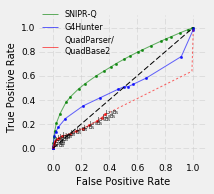

0.697995486616 0.506507432726 0.459941322508


In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2.8))

ax.plot(sniprq_fpr[valr], sniprq_tpr[valr], lw=1, color='green', alpha=0.6, label='SNIPR-Q')
ax.scatter(sniprq_fpr[valr], sniprq_tpr[valr], s=5, color='green', marker='o', alpha=0.9)

ax.plot(hunter_fpr, hunter_tpr, lw=1, color='blue', alpha=0.6, label='G4Hunter')
ax.scatter(hunter_fpr, hunter_tpr, s=5, color='blue', marker='o', alpha=0.9)

sorted_idx_motif = np.argsort(motif_fpr)
extrapolate_slope = ((motif_tpr[sorted_idx_motif][-7]-motif_tpr[sorted_idx_motif][-1]) /
                     (motif_fpr[sorted_idx_motif][-7]-motif_fpr[sorted_idx_motif][-1]))

ax.plot(motif_fpr[sorted_idx_motif], motif_tpr[sorted_idx_motif],
        lw=1, color='red', alpha=0.6, label='QuadParser/\nQuadBase2')
ax.plot([motif_fpr[sorted_idx_motif][-1], 0.99, 1],
        [motif_tpr[sorted_idx_motif][-1], extrapolate_slope, 1],
        lw=1, color='red', alpha=0.6, ls=':')
ax.scatter(motif_fpr[sorted_idx_motif], motif_tpr[sorted_idx_motif],
           s=5, color='red', marker='o', alpha=0.8)

# for i,j,k in zip(cutoff_values[valr], sniprq_fpr[valr],  sniprq_tpr[valr]):
#     ax.text(j,k,i,fontsize=5)
# hunter_cutoffs =  [-4, -1, -0.2, -0.05, -0.02, -0.01, 0, 
#                   0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5]
# for i,j,k in zip(hunter_cutoffs, hunter_fpr, hunter_tpr):
#     ax.text(j,k,i,fontsize=5)
g4_motifs = []
for i in [0, 5]:
    for j in [3, 5, 7, 10, 15, 20, 25]:
        g4_motifs.append(r'L$_{%d}$B$_%d$' % (j, i))
for i,j,k in zip(g4_motifs, motif_fpr[sorted_idx_motif], motif_tpr[sorted_idx_motif]):
    ax.text(j,k,i,fontsize=5)

ax.plot([0,1], [0, 1], lw=1, ls='--', color='k')
clean_axis(ax)
ax.legend(frameon=False, loc=(0, 0.7), fontsize=8, scatterpoints=1)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xlim((-0.1,1.1))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)

plt.tight_layout()
plt.savefig('../images/roc_g4_seq.svg', transparent=True, edgecolor='none')
plt.show()

print (metrics.auc(sniprq_fpr, sniprq_tpr),
       metrics.auc(hunter_fpr, hunter_tpr),
       metrics.auc(list(motif_fpr[sorted_idx_motif])+[1],
                   list(motif_tpr[sorted_idx_motif])+[1]))

In [51]:
for i,j,k in zip(g4_motifs, motif_fpr[sorted_idx_motif], motif_tpr[sorted_idx_motif]):
    print(j,k,i)

0.000589257173409 0.0122601071267 L$_{3}$B$_0$
0.00306269582754 0.0277413622494 L$_{5}$B$_0$
0.00676051391612 0.0406114135322 L$_{7}$B$_0$
0.0144048043898 0.056561797598 L$_{10}$B$_0$
0.0296515607453 0.0753476184244 L$_{15}$B$_0$
0.0455407559353 0.0888406239645 L$_{20}$B$_0$
0.0614392333454 0.0994469176392 L$_{25}$B$_0$
0.120592528883 0.119230689757 L$_{3}$B$_5$
0.165998092012 0.140925416151 L$_{5}$B$_5$
0.210918031226 0.163191056397 L$_{7}$B$_5$
0.25671049913 0.188625038935 L$_{10}$B$_5$
0.311138817021 0.224082921793 L$_{15}$B$_5$
0.345268775966 0.253312792679 L$_{20}$B$_5$
0.371794958597 0.279464626683 L$_{25}$B$_5$


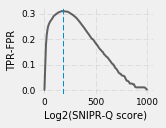

(array([183]),
 array([ 0.31034767]),
 array([ 0.49303791]),
 array([ 0.18269024]),
 array([184]))

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

diff = sniprq_tpr-sniprq_fpr
max_pos = np.where(diff == max(diff))[0]
x = np.array(list(range(1, 200)) + list(range(200, 1010, 10)))

ax.plot(x, diff, lw=2, color='k', alpha=0.6)
ax.set_xlabel('Log2(SNIPR-Q score)', fontsize=10)
ax.set_ylabel('TPR-FPR', fontsize=10)
ax.axvline(x[max_pos], lw=1, ls='--')
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/roc_g4_seq_diff_max_val.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/roc_g4_seq_diff_max_val.svg', transparent=True, edgecolor='none')
plt.show()

max_pos, diff[max_pos], sniprq_tpr[max_pos], sniprq_fpr[max_pos], x[max_pos]